<a href="https://colab.research.google.com/github/zhangxz1123/NN_convergence/blob/master/2a_gam_additive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title Imports

from __future__ import division
from __future__ import print_function
import os.path as osp
import json
import re
from IPython.display import display
from copy import copy
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
#@title Enable v2 behaviour
tf.enable_v2_behavior()


In [0]:
#@title Upload the file "medis984c.data"
from google.colab import files
files.upload()

Saving medis9847c.data to medis9847c.data


{u'medis9847c.data': '82\t0\t1\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t1\t0\t0\t0\t24\t0\t0\t0\t0\t0\t33\t1.8\t0\t0\t0\t0\t0\t0\t0\t15.1\t0\t0\t0\t0\t0\t0\t0\t0\n24\t1\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t17\t0\t0\t1\t0\t0\t0\t26\t0\t0\t0\t0\t30\t0\t0\t0\t0\t3\t0\t7.48\t0\t0\t22.6\t1\t1\t0\t0\t0\t0\t0\t0\n82\t1\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t28\t0\t38.33\t0\t0\t17\t73\t2\t0\t0\t3\t158\t7.54\t48\t0\t4.6\t0\t0\t0\t0\t0\t0\t0\t0\n78\t0\t1\t0\t1\t0\t0\t1\t1\t1\t0\t0\t0\t0\t3\t0\t0\t0\t0\t1\t0\t0\t0\t36\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t46\t0\t12.6\t1\t1\t0\t0\t0\t0\t0\t0\n94\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t1\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t32.5\t0\t0\t0\t165\t11.4\t0\t16.4\t6.7\t154\t6.99\t0\t0\t0\t1\t1\t0\t0\t0\t0\t0\t0\n69\t1\t1\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t1\t0\t0\t0\t22\t0\t0\t0\t0\t0\t0\t0\t0\t0\t2.8\t0\t0\t72\t46\t16.1\t1\t1\t0\t0\t0\t0\t0\t0\n90\t1\t1\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t1\t1\t0\t0\t1\t0\t0\t

In [0]:
def standardize_func(x):
  x_max, x_min = np.max(x), np.min(x)
  if x_min >= x_max:
    # Implies that min and max are same, meaning all values are identical
    return np.zeros_like(x), (x_min, x_max)
  else:
    return standardize(x, x_min, x_max), (x_min, x_max)
  
def standardize(x, x_min, x_max):
  return (2*x - (x_max + x_min))/(x_max - x_min)
  
def normalize(x):
  data_mean = np.mean(x)
  data_var = np.mean(np.square(x - data_mean))
  data_points = (x - data_mean)/(data_var + 1e-8)
  return data_points, (data_mean, data_var)

In [0]:
#@title Dataset Processing

# Read dataset
file_name = "medis9847c.data"
df = pd.read_csv(file_name, header = None, sep='\t')
val = df.values

# extract the age feature and normalize it to within the range where most activation threshold lies
x = val[:, 0]
# extract the labels
y = val[:,-1]

# Process and plot dataset  

data_points, _ = standardize_func(x)

#"""
data_points = data_points[:, np.newaxis]
data_targets = y

NUM_DATAPOINTS = len(data_points)

plt.figure(figsize=(10, 10))
plt.plot(data_points, data_targets, 'bo', label='original data')
plt.show()

In [0]:
df_train = df.iloc[:, :-1]
df_out = df.iloc[:, -1]
df_max = df_train.max(axis=0)
df_min = df_train.min(axis=0)
df_train = standardize(df_train, df_min, df_max)

In [0]:
msk = np.random.rand(len(df_train)) <= 0.9
x_train = df_train[msk].values
y_train = df_out[msk].values
x_test = df_train[~msk].values
y_test = df_out[~msk].values

In [0]:
data_points = x_train
# Convert data targets to float
data_targets = 1.0 * y_train
NUM_DATAPOINTS = len(data_points)

In [0]:
#@title Model Helpers

class RBFLayer(tf.keras.layers.Layer):
  
  def __init__(self, num_units, trainable=True, center_init=(-1, 1)):
    super(RBFLayer, self).__init__(trainable=trainable)
    self.num_units = num_units  
    sgn = 2 * np.random.randint(2, size = self.num_units) - 1
    self.sgn = tf.cast(sgn, dtype=tf.float64)
    # Initializing this to lie within the data range
    self._min_val, self._max_val = center_init

  def build(self, input_shape):
    self.beta = self.add_weight(
        name='beta',
        shape=[input_shape[-1], self.num_units],
        initializer=tf.initializers.constant(5.0),
        trainable=True)
    self.c = self.add_weight(
        name='c',
        shape=[1, self.num_units],
        initializer=tf.initializers.truncated_normal(stddev=0.5), 
            # self._min_val, self._max_val),
        trainable=True)

  def call(self, x):
    center = tf.tile(self.c, [tf.shape(x)[0], 1])
    distances = tf.abs(x - center)
    out = tf.exp(self.beta) * (x - center)
    out = tf.clip_by_value(self.sgn * out, -1, 1)
    # out = tf.tanh(out)
    return out


class SimpleNN(tf.keras.Model):
  """Simple NN model."""

  def __init__(self, num_units, **kwargs):
    super(SimpleNN, self).__init__()
    self.rbf_layer = RBFLayer(num_units, **kwargs)
    # self.batch_norm = tf.keras.layers.BatchNormalization()
    self.linear = tf.keras.layers.Dense(
        1, use_bias=True,
        kernel_initializer=tf.initializers.random_uniform(-1, 1))
   
  def call(self, x, training=True):
    x = self.rbf_layer(x)
    # x = self.batch_norm(x, training=training)
    x = tf.squeeze(self.linear(x), axis=-1)
    return x 


class ComplexNN(tf.keras.Model):
  def __init__(self, num_inputs, num_units, **kwargs):
    super(ComplexNN, self).__init__()
    self.num_inputs = num_inputs
    self.simple_nns = [SimpleNN(num_units, **kwargs)
                       for _ in range(num_inputs)]
    
  def call(self, x, training=True):
    return tf.add_n(self.calc_outputs(x, training=training)) 

  def calc_outputs(self, x, training=True):
    list_x = tf.split(x, self.num_inputs, axis=-1)
    return [self.simple_nns[i](x_i, training=training) for i, x_i in enumerate(list_x)] 

In [0]:
#@title Create tf Dataset
# Assume that each row of `features` corresponds to the same row as `labels`.
assert data_points.shape[0] == data_targets.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((data_points, data_targets))

BATCH_SIZE = 1024 #@param {type: "integer"}
BATCH_SIZE = min(BATCH_SIZE, NUM_DATAPOINTS)
# ds_tensors = dataset.map(lambda x, y : (x/100, y))
ds_tensors = dataset 
ds_tensors = ds_tensors.apply(tf.data.experimental.shuffle_and_repeat(
    buffer_size=NUM_DATAPOINTS)).batch(BATCH_SIZE)

data_points_tensor = tf.convert_to_tensor(data_points)


In [0]:
x1 = nn_model.calc_outputs(data_points_tensor[:BATCH_SIZE], training=False)

In [0]:
#@title Training Helpers

def cross_entropy_loss(model, inputs, targets):
  predicted_y = model(inputs)
  logits = tf.stack([predicted_y, tf.zeros_like(predicted_y)], axis=1)
  labels = tf.stack([targets, 1 - targets], axis=1)
  loss_vals = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=labels, logits=logits)
  return tf.reduce_mean(loss_vals)

def ce_loss(logits, targets):
  logits = tf.stack([logits, tf.zeros_like(logits)], axis=1)
  labels = tf.stack([targets, 1 - targets], axis=1)
  loss_vals = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=labels, logits=logits)
  return tf.reduce_mean(loss_vals)

def penalized_cross_entropy_loss(model, inputs, targets, reg=1e-4):
  ce_loss = cross_entropy_loss(model, inputs, targets)
  reg_loss = reg * logit_regularization_ce(model, inputs, targets)
  return ce_loss + reg_loss

def logit_regularization(model, inputs):
  per_feature_logits = model.calc_outputs(inputs)
  per_feature_norm = [tf.norm(logits, ord=1) for logits in per_feature_logits]
  return tf.add_n(per_feature_norm) / len(per_feature_norm)

def logit_regularization_ce(model, inputs, targets):
  per_feature_logits = model.calc_outputs(inputs)
  per_feature_ce = [ce_loss(logits, targets) for logits in per_feature_logits]
  return tf.add_n(per_feature_ce) / len(per_feature_ce)

def mse_loss(model, inputs, targets):
  predicted = model(inputs)
  return tf.losses.mean_squared_error(predicted, targets)
  

def grad(model, inputs, targets, loss_fn=cross_entropy_loss, train_vars=None):
  with tf.GradientTape() as tape:
    loss_value = loss_fn(model, inputs, targets)
  if train_vars is None:
    train_vars = model.trainable_variables
  return loss_value, tape.gradient(loss_value, train_vars)

In [0]:
#@title Neural Network Model
# center_init = (np.min(data_points), np.max(data_points))
center_init = (-1, 1)
num_units = 200 #@param {"type":"integer"}
num_inputs = data_points.shape[-1]
nn_model = ComplexNN(num_inputs=num_inputs, 
                     num_units=num_units,
                     center_init=center_init)
print(nn_model(data_points_tensor[:BATCH_SIZE], training=False))
nn_model.summary()

tf.Tensor(
[ 26.58674785   3.37514559  37.25251274 ... -19.73767765  20.93944448
 -51.08793062], shape=(1024,), dtype=float64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_nn_1150 (SimpleNN)    multiple                  601       
_________________________________________________________________
simple_nn_1151 (SimpleNN)    multiple                  601       
_________________________________________________________________
simple_nn_1152 (SimpleNN)    multiple                  601       
_________________________________________________________________
simple_nn_1153 (SimpleNN)    multiple                  601       
_________________________________________________________________
simple_nn_1154 (SimpleNN)    multiple                  601       
_________________________________________________________________
simple_nn_1155 (SimpleNN)    multiple                  601       
_______________

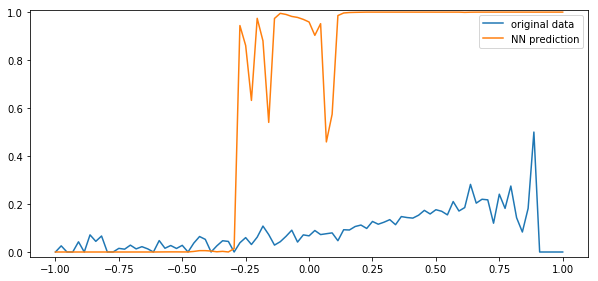

In [0]:
#@title Plot helpers

def plot_hist(index=0, figsize=(10, 10)):  
  val = data_targets
  age = data_points[:, index:index+1]
  unique_age = np.unique(age)
  get_indices = lambda i:  np.multiply(age[:,0] >= i-0, age[:,0] <= i+0)
  h = np.asarray([np.mean(val[get_indices(i)]) for i in unique_age]) # the histogram
  ## Plot the results
  plt.figure(figsize = figsize)

  plt.subplot(2,1,1)
  ## The marginalization plot p(y|x), which is the optimal predictor
  plt.plot(unique_age, h, label = 'original data')

  ## The plot of the neural net's prediction
  pred = nn_model.simple_nns[index](unique_age[:, np.newaxis], training=False)
  pred = tf.sigmoid(pred).numpy()
  plt.plot(unique_age, pred, label = 'NN prediction')
  plt.legend()
  plt.ylim(-0.02, 1.01)
  plt.show()

# def plot_fig():
#   plt.figure(figsize = (10, 10))
#   plt.subplot(2,1,1)
#   plt.title('label vs. prediction')
#   plt.plot(data_points, data_targets,'o',label = 'original data')
#   pred_logits = nn_model.simple_nns(data_points)
#   predicted = tf.sigmoid(pred_logits).numpy()
#   plt.plot(data_points, predicted, 'x', label = 'NN prediction')
#   plt.legend()
#   plt.show()

# plot_fig()
plot_hist(index=0)


Rank 78
Singular values-> Min: 4.2564893711e-43 Max: 1184.63593368


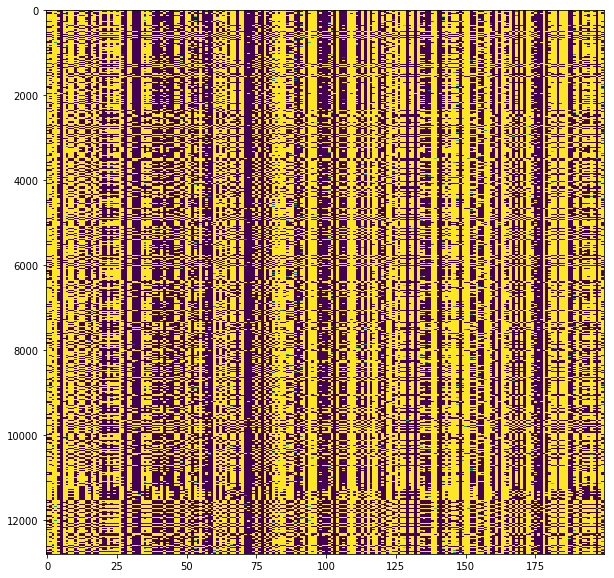

In [0]:
#@title Feature matrix Inspection 
# Code from Simon Kornblith 

unique_age = np.unique(data_points[:, 0])
X = nn_model.simple_nns[0].rbf_layer(data_points_tensor[:, :1])

plt.gcf().set_size_inches((10, 10))
plt.imshow(X, aspect='auto', interpolation='nearest')

# Calculate rank and eigenvalues
rank = np.linalg.matrix_rank(X)
print('Rank {}'.format(rank))

# Singular values of the feature matrix
eigs = np.linalg.svd(X, full_matrices=False, compute_uv=False)
print('Singular values-> Min: {} Max: {}'.format(np.min(eigs), np.max(eigs)))

# assert rank >= len(unique_age), "Rank should be at least number of unique " \
# "datapoints to fit data perfectly"

In [0]:
#@title Learning Rate Decay
learning_rate = 1e-2
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    learning_rate, 
    global_step, 
    decay_steps=200,
    decay_rate=0.8)
optimizer = tf.train.AdamOptimizer(learning_rate)
model = nn_model

In [0]:
import functools

In [0]:
#@title Gradient Descent Training
train_loss_results = []
train_accuracy_results = []

iteration = 0
num_iters_per_epoch = (NUM_DATAPOINTS // BATCH_SIZE)
num_epochs = 20 #@param
num_iters = num_epochs * num_iters_per_epoch
epoch = 0

tfe = tf.contrib.eager
epoch_loss_avg = tfe.metrics.Mean()
epoch_accuracy = tfe.metrics.Accuracy()
loss_fn = functools.partial(penalized_cross_entropy_loss, reg=1e-2)
grad_fn = lambda x, y, z=None: grad(
    model, x, y, loss_fn=loss_fn, train_vars=z)
train_vars = model.trainable_variables

# Training loop - using batches of size `BATCH_SIZE`
for x, y in ds_tensors:   
  # Optimize the model
  loss_value, grads = grad_fn(x, y, train_vars)
  optimizer.apply_gradients(
      zip(grads, train_vars), global_step)

  # Track progress
  epoch_loss_avg(loss_value)  # add current batch loss
  # compare predicted label to actual label
  epoch_accuracy(tf.cast(model(x, training=False) > 0, dtype=tf.int32),
                tf.cast(y > 0.5, dtype=tf.int32))
  
  if (iteration + 1) % num_iters_per_epoch == 0:
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Iter {:03d}: Loss: {:.6f} Accuracy: {:.3f}".format(
        iteration, epoch_loss_avg.result(),
        epoch_accuracy.result()))
          
    if (iteration + 1) % (num_iters_per_epoch * 10) == 0:
      print('Plot in Iteration {}'.format(iteration))
      plot_hist()

    # reset epoch counters
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

  iteration += 1
  if iteration > num_iters:
    break

Iter 011: Loss: 0.607329 Accuracy: 0.877
Iter 023: Loss: 0.526886 Accuracy: 0.880
Iter 035: Loss: 0.719872 Accuracy: 0.858
Iter 047: Loss: 0.507995 Accuracy: 0.881
Iter 059: Loss: 0.438194 Accuracy: 0.887
Iter 071: Loss: 0.413440 Accuracy: 0.885
Iter 083: Loss: 0.553901 Accuracy: 0.876
Iter 095: Loss: 0.758411 Accuracy: 0.851
Iter 107: Loss: 0.624545 Accuracy: 0.874


In [0]:
from google.colab import widgets
from matplotlib import pylab

In [0]:
def plot_all_hist():
  num_cols = 4
  num_rows = int(np.ceil(num_inputs * 1.0 / num_cols))
  grid = widgets.Grid(num_rows, num_cols)
  figsize = (13 - num_cols, 13 - num_cols)
  for i, (row, col) in enumerate(grid):
    if i >= num_inputs:
      break
    plot_hist(i, figsize)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

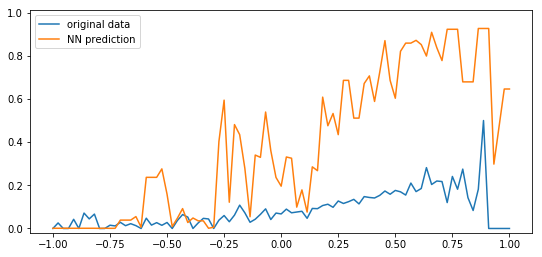

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

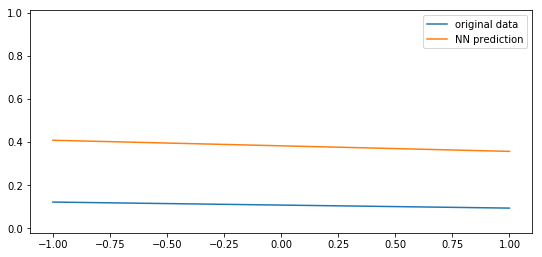

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

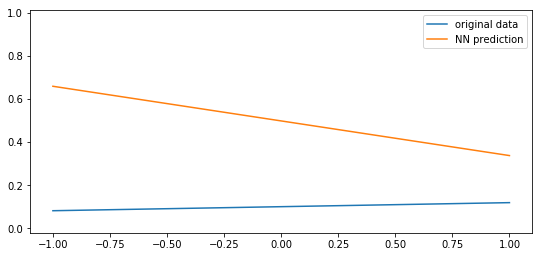

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

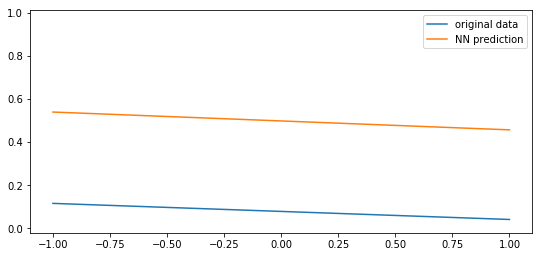

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

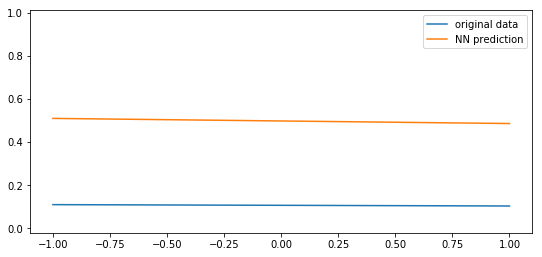

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

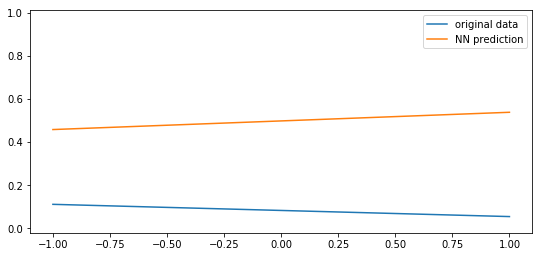

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

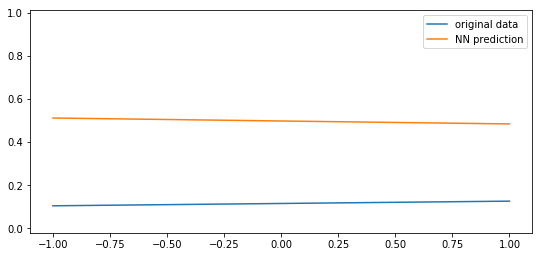

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

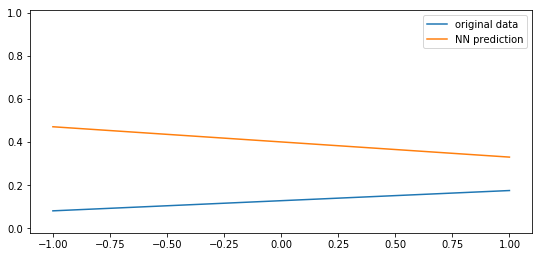

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

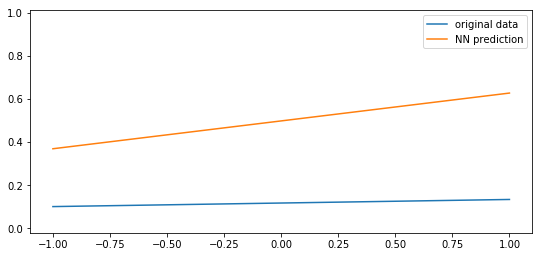

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

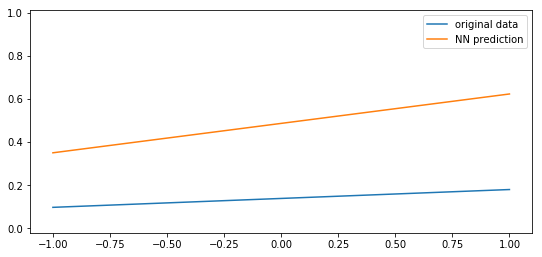

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

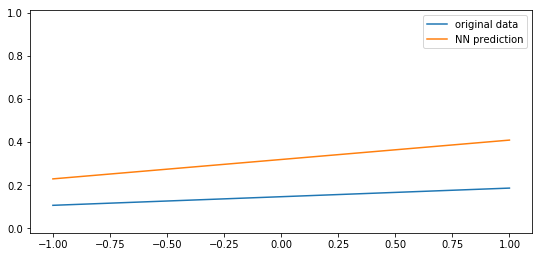

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

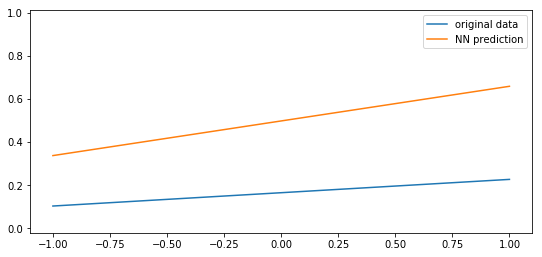

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

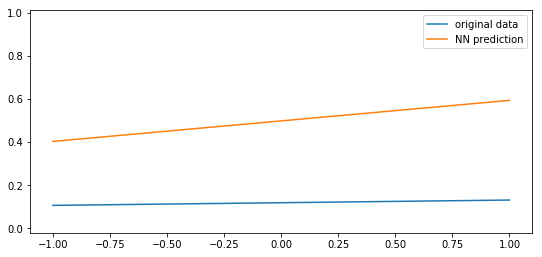

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

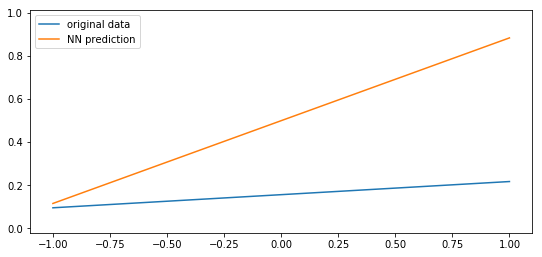

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

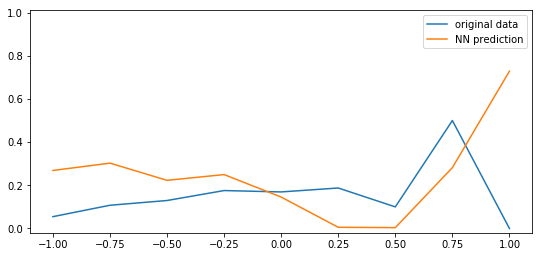

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

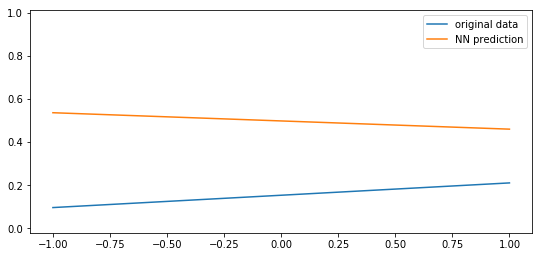

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

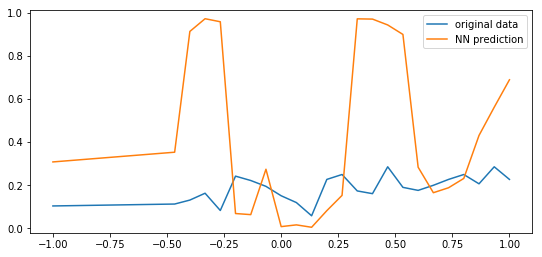

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

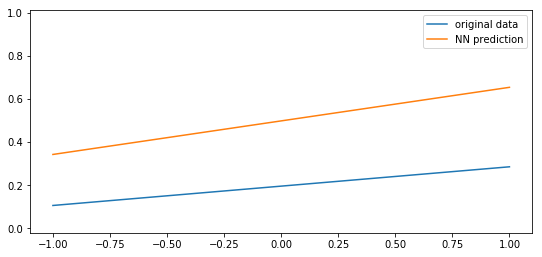

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

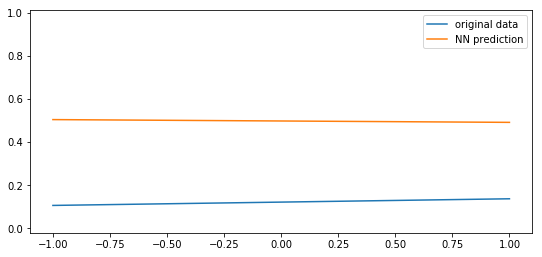

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

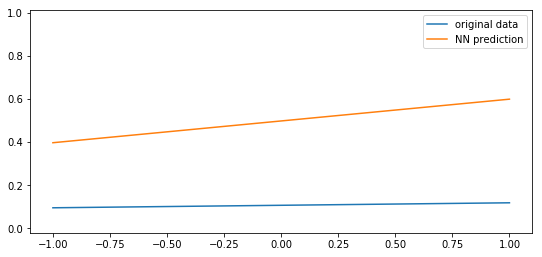

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

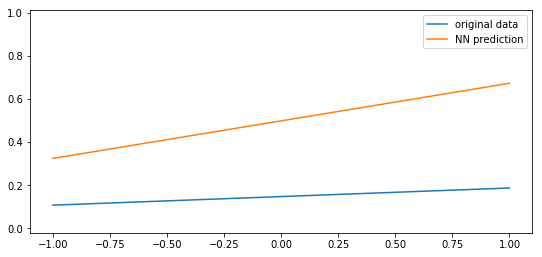

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

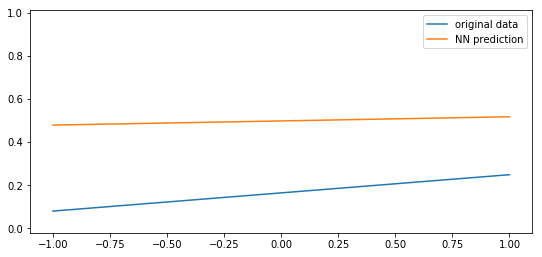

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

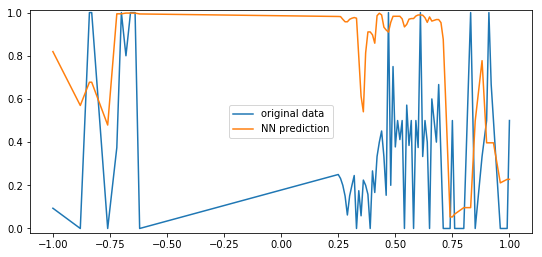

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

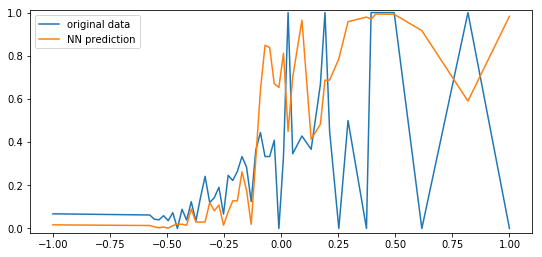

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

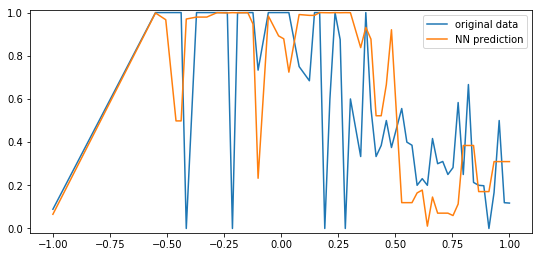

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

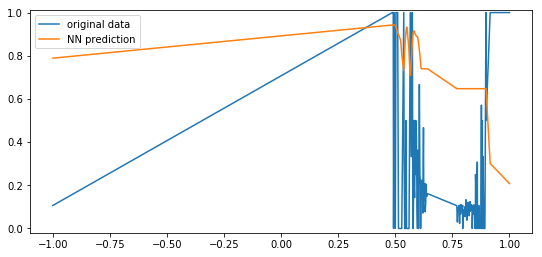

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

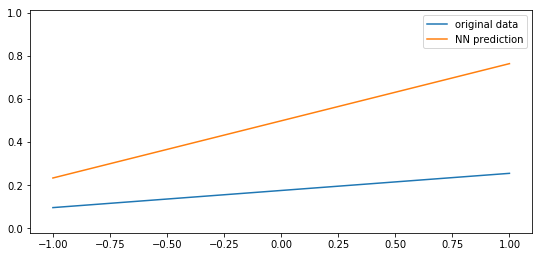

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

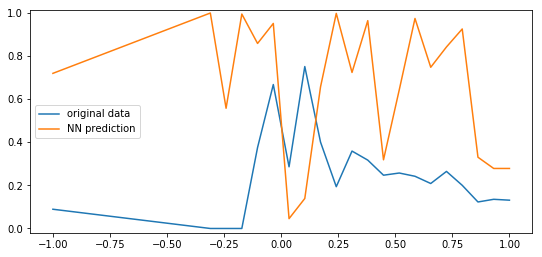

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

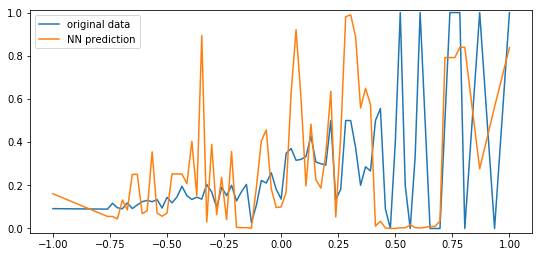

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

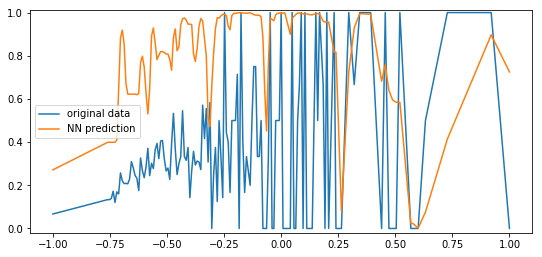

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

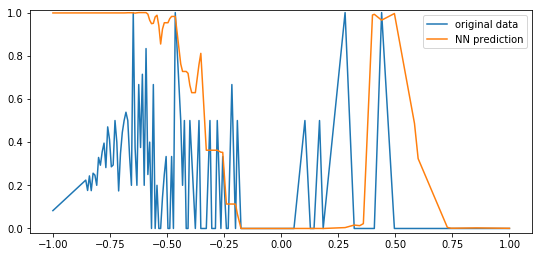

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

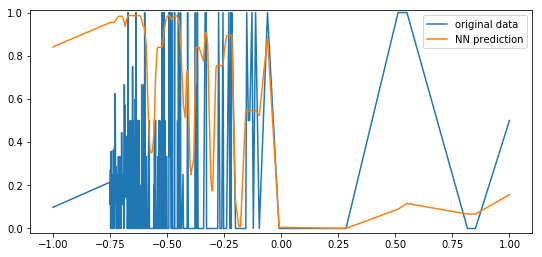

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

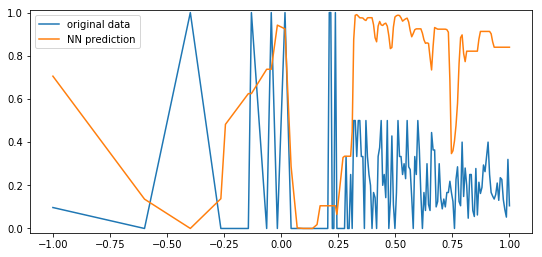

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

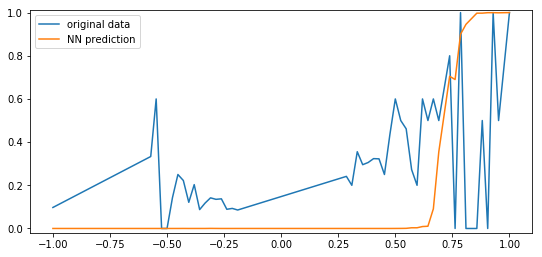

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

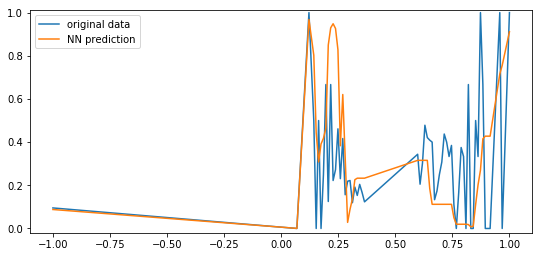

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

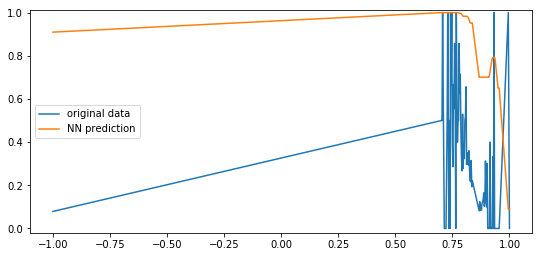

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

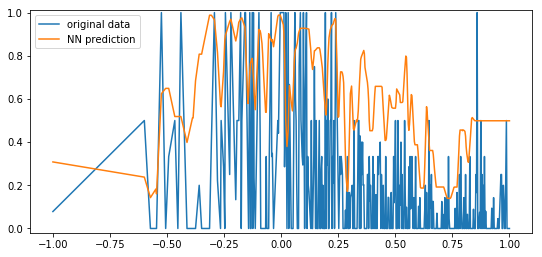

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

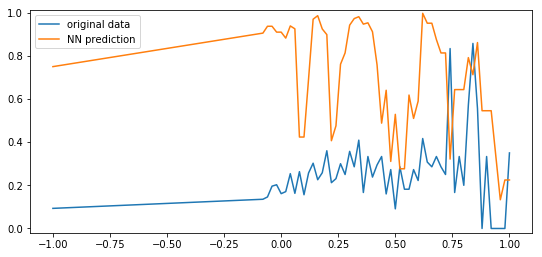

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

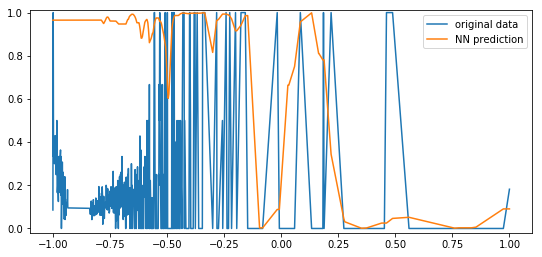

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

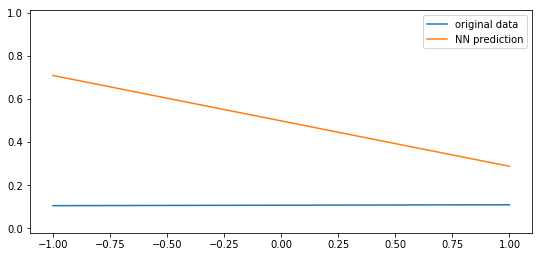

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

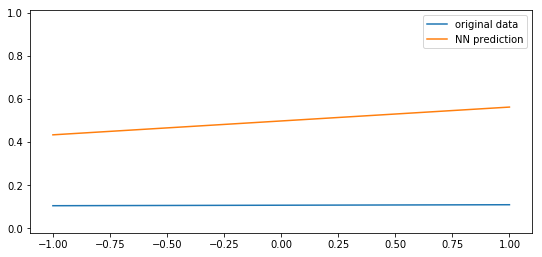

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

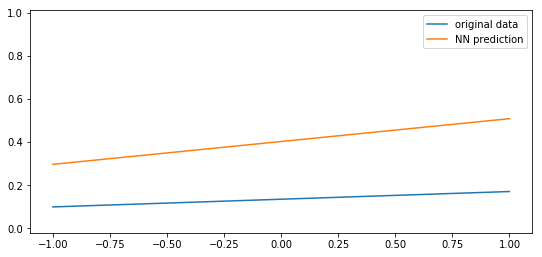

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

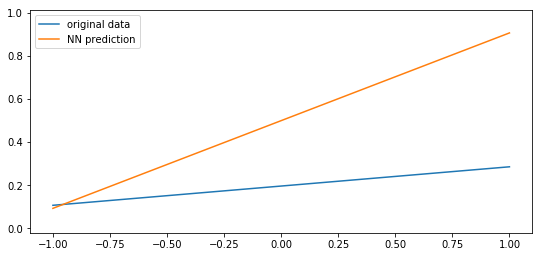

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

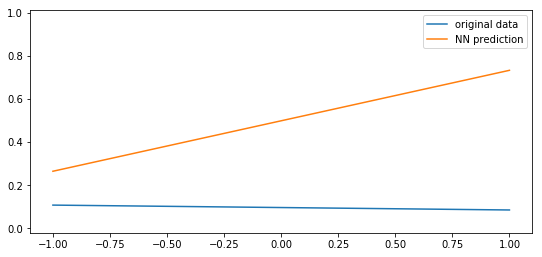

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

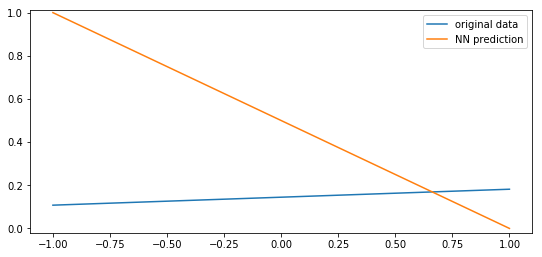

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

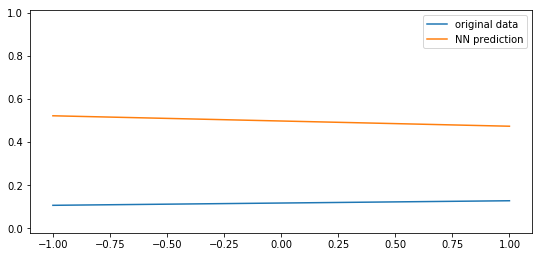

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
#@title Histogram plot after few gradient descent steps
plot_all_hist()

In [0]:
#@title Smaller Model
plot_all_hist()

## Second Order Optimization

## TODO: Fix this code for additive GAM

---



In [0]:
#@title Helpers for using Scipy Optimize 
import scipy.optimize

compute_loss = lambda x: cross_entropy_loss(x, data_points_tensor, data_targets)

def extract_weights(x):
  return [x[:-1, np.newaxis], x[-1, np.newaxis]]  

def merge_weights(W, b):
  return np.concatenate((W.numpy().ravel(), b.numpy()), 0)

def get_nn_vars():
  return nn_model.simple_nns[0].layers[-1].trainable_variables
  
def optfun(x):
  x1 = extract_weights(x)
  nn_model.simple_nns[0].layers[-1].set_weights(x1)  
  return compute_loss(nn_model).numpy()

def jacfun(x):
  x1 = extract_weights(x)
  layer = nn_model.simple_nns[0].layers[-1]
  layer.set_weights(x1)
  with tf.GradientTape() as tape:
    loss = compute_loss(nn_model)
  W_grad, b_grad = tape.gradient(
      loss, layer.trainable_variables)
  return merge_weights(W_grad, b_grad)

In [0]:
#@title Train using a second order optimizer until convergence.
x_init = merge_weights(*get_nn_vars())
res_no_ls = scipy.optimize.minimize(
    optfun, x_init, jac=jacfun, method='L-BFGS-B', 
    tol=1e-8, options={'disp': True})

res_no_ls
print(res_no_ls)

In [0]:
#@title After Second order Optimization
plot_hist()